# Lab 1: Regression

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD1"** in the mail subject or I might lose your work (which means 0) and send it to 
houssam.zenati@inria.fr

Please label your notebook **"L1_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [341]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = \beta x + b
$$
where $\beta$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

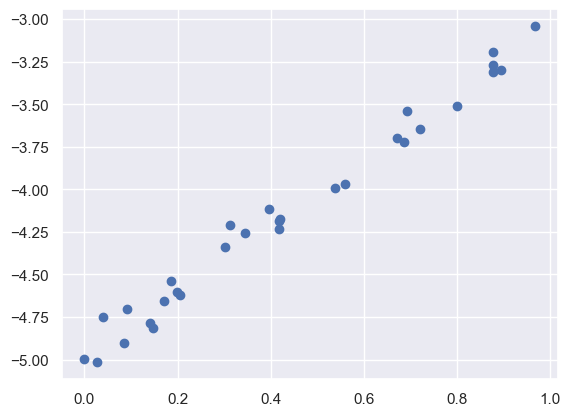

In [342]:
rng = np.random.RandomState(1)
x =  rng.rand(30)
y = 2 * x - 5 + 0.1* rng.randn(30)
plt.scatter(x, y)

Fill in the MultivariateLinearRegression class whose method fit takes a matrix $X$ and an array $y$ as input and returns an array of coefficients

In [343]:
class MultivariateLinearRegression():
    # Class for linear regression solving least-squares:

    def __init__(self,):
        self.coef_ = None
        
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        # Create a (num_samples, num_features+1) np.array X_aug whose first column 
        # is a column of all ones (so as to fit an intercept).
        X_aug = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

        # Update self.coef_
        self.coef_ = np.linalg.pinv(X_aug.T @ X_aug) @ X_aug.T @ y
        
    def predict(self, X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        X_aug = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        return X_aug @ self.coef_

Try your model on the data and plot the data points and the fitted line:

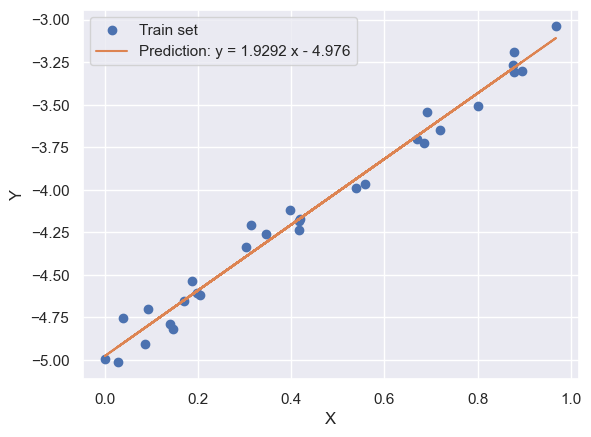

In [344]:
X = x.reshape(-1,1)
model_base = MultivariateLinearRegression()
model_base.fit(X, y)
preds = model_base.predict(X)

b, a = model_base.coef_
plt.scatter(x,y, label="Train set")
plt.plot(x, preds, label=f"Prediction: y = {round(a, 4)} x {'+' if b > 0 else '-'} {round(abs(b), 4)}", c="C1")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

Print the scope and the intercept:

In [345]:
print("Model slope:    ", model_base.coef_[1])
print("Model intercept:", model_base.coef_[0])

Model slope:     1.9292055341290553
Model intercept: -4.976046835178198


We see that the results are very close to the inputs, as we might hope.

Of course our linear regression estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots
$$
where there are multiple $x$ values.
Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building a toy example:

In [346]:
rng = np.random.RandomState(1)
X = 3 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model_base.fit(X, y)
print(model_base.coef_) # perfect fitting
print("maximum absolute error:",max(np.abs(y-model_base.predict(X))))

[ 0.5  1.5 -2.   1. ]
maximum absolute error: 1.509903313490213e-14


Here the $y$ data is constructed from three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

In this way, we fit lines, planes, or hyperplanes to our data.
It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

## Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.

The idea is to take our multidimensional linear model:
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \cdots
$$
and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:
$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \cdots
$$
Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

### Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the ``PolynomialFeatures`` transformer:

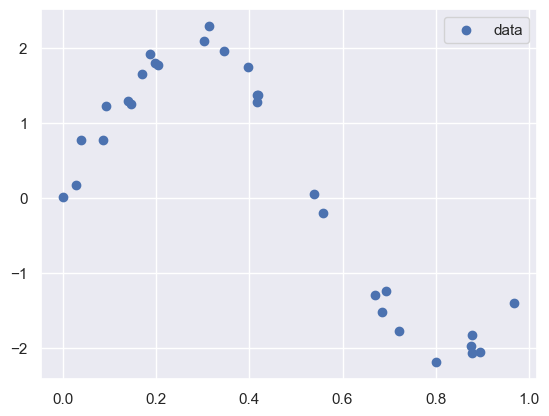

In [347]:
from sklearn.preprocessing import PolynomialFeatures

rng = np.random.RandomState(1)
x = rng.rand(30)
y = 2 * np.sin(1.8*np.pi*x) + 0.2 * rng.randn(30)

plt.scatter(x, y, label="data")
plt.legend()
plt.show()

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.
This new, higher-dimensional data representation can then be plugged into a linear regression

With this transform, we can use the linear model to fit much more complicated relationships between $x$ and $y$. 
For example, here is a sine wave with noise:

In [348]:
def plot_results(x, models, names, transforms=None, n=1000):
    if transforms is None:
        transforms = [None]*len(models)
    x_arr = np.linspace(min(x), max(x), n)
    plt.scatter(x,y, label="Train set", c="black", s=15)
    for i, (model, name, poly) in enumerate(zip(models, names, transforms)):
        if poly is not None:
            x_features = poly.transform(x_arr[:, None])
        else:
            x_features = x_arr[:, None]
        plt.plot(x_arr, model.predict(x_features), label=f"Prediction - {name}", c=f"C{i}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

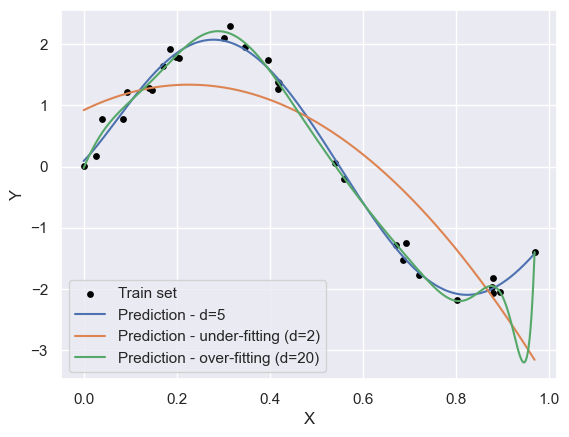

In [349]:
poly = PolynomialFeatures(5, include_bias=False) # with or without intercept
model_base = MultivariateLinearRegression()
model_base.fit(poly.fit_transform(x[:, None]), y)

poly_under = PolynomialFeatures(2, include_bias=False) # with or without intercept
model_base_under = MultivariateLinearRegression()
model_base_under.fit(poly_under.fit_transform(x[:, None]), y)

poly_over = PolynomialFeatures(20, include_bias=False) # with or without intercept
model_base_over = MultivariateLinearRegression()
model_base_over.fit(poly_over.fit_transform(x[:, None]), y)

plot_results(x, [model_base, model_base_under, model_base_over], ["d=5", "under-fitting (d=2)", "over-fitting (d=20)"], [poly, poly_under, poly_over])

Try with different maximum degrees. Our linear model can provide an excellent fit to this non-linear data!

**Bonus:** How can we avoid overfitting?

**Answer:** We should not take a too high maximum degree (to avoid aving too much parameters). An other solution may be to add regularization

## Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting.

With the data projected to the 30-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data.
We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*.
This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be 
$$
P = \alpha\sum_{i=1}^n \beta_i^2
$$
where $\alpha$ is a free parameter that controls the strength of the penalty.

 Fill in the following class:

In [350]:
class RidgeRegularization():
    # Class for ridge regression with closed form equation:

    def __init__(self, alpha):
        self.coef_ = None
        self.alpha_ = alpha
        
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        X_aug = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        A = np.eye(X_aug.shape[1])
        A[0, 0] = 0
        # Update self.coef_ adding the shrinkage ridge term
        self.coef_ = np.linalg.pinv(X_aug.T @ X_aug + self.alpha_*A) @ X_aug.T @ y
        

    def predict(self, X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        X_aug = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        return X_aug @ self.coef_

Try the model in our data. Plot the coefficients of the regression.

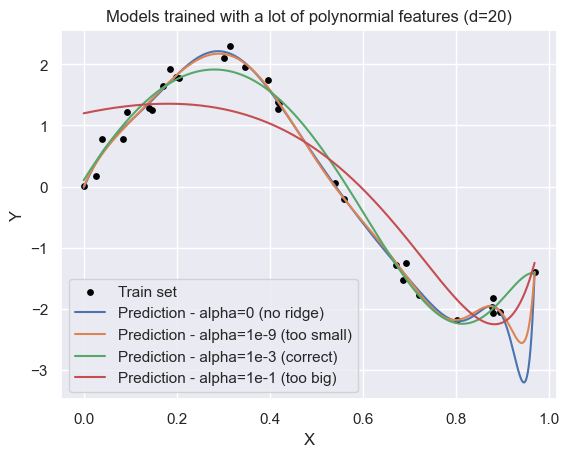

In [351]:
X_features = poly_over.fit_transform(x[:, None])

model_ridge = RidgeRegularization(1e-3)
model_ridge.fit(X_features, y)

model_ridge_small_reg = RidgeRegularization(1e-1)
model_ridge_small_reg.fit(X_features, y)

model_ridge_big_reg = RidgeRegularization(1e-9)
model_ridge_big_reg.fit(X_features, y)

plot_results(
    x,
    [model_base_over, model_ridge_big_reg, model_ridge, model_ridge_small_reg],
    ["alpha=0 (no ridge)", "alpha=1e-9 (too small)", "alpha=1e-3 (correct)", "alpha=1e-1 (too big)"],
    [poly_over]*4
)
plt.title("Models trained with a lot of polynormial features (d=20)")
plt.show()

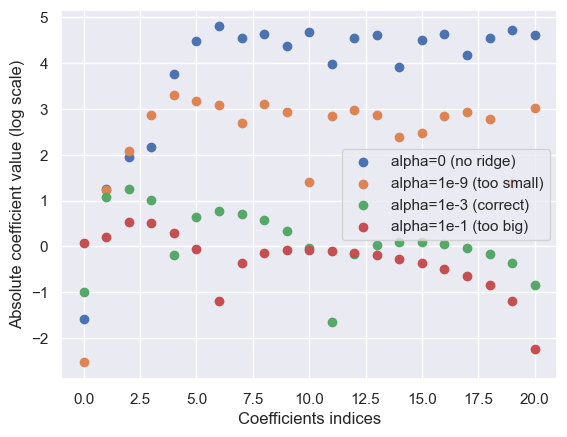

In [352]:
for model, name in zip(
    [model_base_over, model_ridge_big_reg, model_ridge, model_ridge_small_reg],
    ["alpha=0 (no ridge)", "alpha=1e-9 (too small)", "alpha=1e-3 (correct)", "alpha=1e-1 (too big)"]
):
    coefs = model.coef_
    plt.scatter(list(range(len(coefs))), np.log10(np.abs(coefs)), label=name)
plt.legend()
plt.xlabel("Coefficients indices")
plt.ylabel("Absolute coefficient value (log scale)")
plt.show()

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model.
In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.

**Bonus:** How can we choose the $\alpha$ parameter?

**Answer:** We could optimize it using cross validation evaluation

### Lasso regression ($L_1$ Regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:
$$P = \alpha\sum_{i=1}^n |\beta_i|$$
Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients.

First, fill in the following class:

In [353]:
class LassoRegularization():
    # Class for lasso regression with soft thresholding:

    def __init__(self, alpha, learning_rate=0.01, iterations=10000):
        self.coef_ = None
        self.alpha = alpha
        self.learning_rate_ = learning_rate
        self.iterations_ = iterations
        
    def soft_threshold(self, beta):
        """ Soft threshold function"""
        return np.sign(beta)*np.maximum(np.zeros(beta.shape), np.abs(beta) - self.alpha)

    def fit(self, X, y):
        """ Fit the data (X, y).
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        X_aug = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        # initialisation
        self.coef_ = np.random.rand(X_aug.shape[1])
        
        for _ in range(self.iterations_):
            beta_tilde = self.coef_ - self.learning_rate_ * (-X_aug.T @ y + X_aug.T @ X_aug @ self.coef_)
            self.coef_ = self.soft_threshold(beta_tilde)
            
        # Update self.coef_ by using the coordinate soft thresholding algorithm

    def predict(self, X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
    
        X_aug = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        return X_aug @ self.coef_

Try the model in our data. Plot the coefficients of the regression and compare them to the Ridge's coefficients.

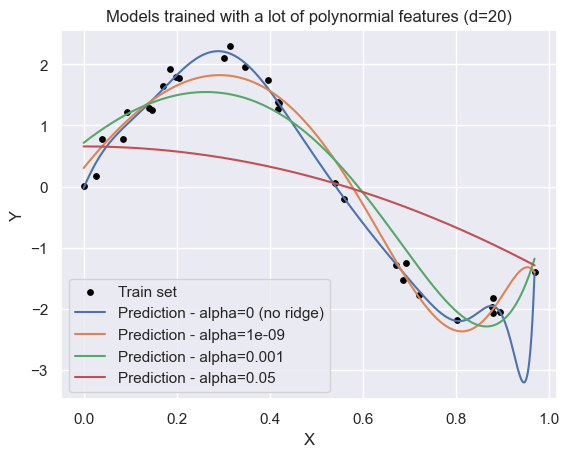

In [354]:
model_lasso = LassoRegularization(1e-3)
model_lasso.fit(X_features, y)

model_lasso_small_reg = LassoRegularization(5e-2)
model_lasso_small_reg.fit(X_features, y)

model_lasso_big_reg = LassoRegularization(1e-9)
model_lasso_big_reg.fit(X_features, y)

plot_results(
    x,
    [model_base_over, model_lasso_big_reg, model_lasso, model_lasso_small_reg],
    ["alpha=0 (no ridge)", f"alpha={model_lasso_big_reg.alpha}", f"alpha={model_lasso.alpha}", f"alpha={model_lasso_small_reg.alpha}"],
    [poly_over]*4
)
plt.title("Models trained with a lot of polynormial features (d=20)")
plt.show()

C:\Users\bouet\AppData\Local\Temp\ipykernel_11524\2263112844.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(list(range(len(coefs))), np.log10(np.abs(coefs)), label=name)


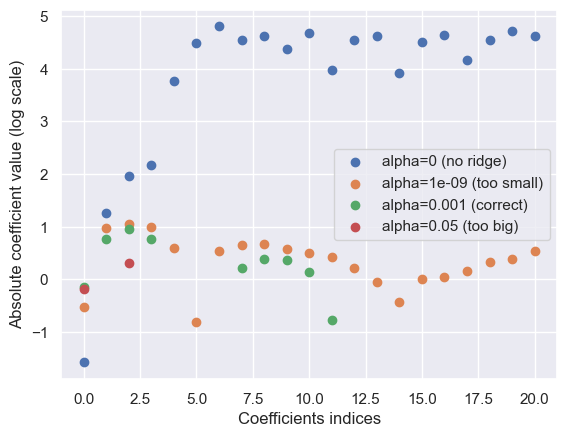

In [355]:
for model, name in zip(
    [model_base_over, model_lasso_big_reg, model_lasso, model_lasso_small_reg],
    ["alpha=0 (no ridge)", f"alpha={model_lasso_big_reg.alpha} (too small)", f"alpha={model_lasso.alpha} (correct)", f"alpha={model_lasso_small_reg.alpha} (too big)"],
):
    coefs = model.coef_
    plt.scatter(list(range(len(coefs))), np.log10(np.abs(coefs)), label=name)
plt.legend()
plt.xlabel("Coefficients indices")
plt.ylabel("Absolute coefficient value (log scale)")
plt.show()

## Robust regression

Linear least-squares estimates can behave badly when the error distribution is not normal, particularly when
the errors are heavy-tailed. One remedy is to remove influential observations from the least-squares fit. Another approach, termed robust regression, is to employ a fitting criterion that is not as vulnerable as least squares to unusual data.

The most common general method of robust regression is M-estimation, introduced by Huber (1964).

Fill in the following class:

In [356]:
class RobustRegression():
    # Class for robust linear regression:

    def __init__(self, potential, k, iterations=10000):
        self.coef_ = None
        self.potencial_ = potential
        self.k_ = k
        self.iterations = iterations

    def weight_function(self, x, potential, k):
        """ Calculate weigth of point residual x.
    
        Parameters:
        -----------
        x: standarize by mad residual
        potential: name of the potential to use:
         "huber" or "bisquare"
        k: parameter of the potential function
        
        Returns:
        -----
        weight: weight corresponding to x 
        """
        if potential == "huber":
            d_w = np.where(np.abs(x) <= k, x, k * np.sign(x))
        elif potential == "bisquare":
            d_w = np.where(np.abs(x) <= k, x * (1 - (x**2 / k**2))**2, 0)
        w_e = d_w/x
        
        return np.diag(w_e)
    
    
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        X_aug = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        # initialisation
        self.coef_ = np.random.rand(X_aug.shape[1])
        
        for _ in range(self.iterations):
            W = self.weight_function(np.abs(y-X_aug@self.coef_), self.potencial_, self.k_)
            self.coef_ = np.linalg.pinv(X_aug.T @ W @ X_aug) @ X_aug.T @ W @ y
        
            
        # Create a (num_samples, num_features+1) np.array X_aug whose first column 
        # is a column of all ones (so as to fit an intercept).
        
        # Start with initial coefficients 

        # Iteratively update coefficients by weighted least-squares until convergence
        
    def predict(self, X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        
        X_aug = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        return X_aug @ self.coef_

Try it in the following data with outliers coming from the heavy-tail error and compare with the performance of the other models:

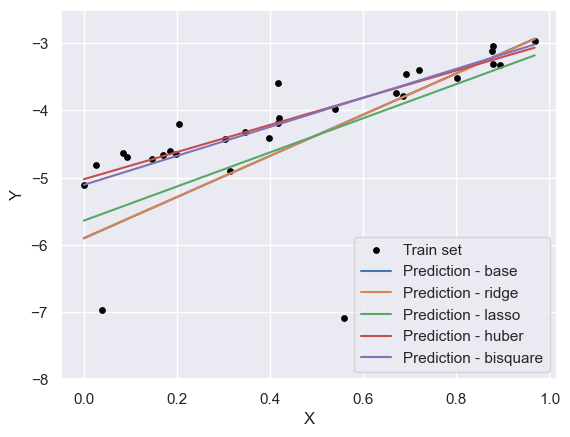

In [357]:
np.random.seed(300)
N = 30
rng = np.random.RandomState(1)
x =  rng.rand(N)
y = 2 * x - 5 + 0.1* np.random.standard_cauchy(N)

X = x[:, None]

model_base_2 = MultivariateLinearRegression()
model_base_2.fit(X, y)

model_ridge_2 = RidgeRegularization(1e-2)
model_ridge_2.fit(X, y)

model_lasso_2 = LassoRegularization(1e-2)
model_lasso_2.fit(X, y)

model_bisquare = RobustRegression("bisquare", 4)
model_bisquare.fit(X, y)

model_huber = RobustRegression("huber", 1e-1)
model_huber.fit(X, y)

plot_results(x, [model_base_2, model_ridge_2, model_lasso_2, model_huber, model_bisquare], ["base", "ridge", "lasso", "huber", "bisquare"])
plt.ylim([-8, -2.5])
plt.show()

Even with the best regularization parameters, the ridge and lasso regularization fail to "ignore" the outliers. On the contrary, the robust regression (hubert of bisquare) succeed (with the correct parameters) to retrieve the exact latent distribution

## Bonus: Predicting Bicycle Traffic

As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

In this section, we joinned the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor.

As you may now, we should use time series techniques to analyze this dataset, instead, as a first simple approach, we will perform a multivariate linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

Let's start by loading the dataset:

In [374]:
import pandas as pd
daily_df = pd.read_csv('data.csv', index_col='Date', parse_dates=True)

With this in place, we can choose the columns to use, and fit a linear regression model to our data:

In [375]:
daily_df.dropna()

def day_to_angle(row):
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    # Find the index of the day that is marked as 1 (i.e. binary day columns)
    day_index = next(i for i, day in enumerate(days) if row[day] == 1)
    # Map day index to radians (cylindrical coordinates)
    angle = 2 * np.pi * day_index / 7
    return angle

# Step 1: Apply the function to create a new column with the angle
daily_df['day_angle'] = daily_df.apply(day_to_angle, axis=1)
daily_df['day_cos'] = np.cos(daily_df['day_angle'])

daily_df = daily_df.drop(columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'day_angle'])


In [376]:
x = daily_df.drop(columns=["Total"]).values
y = daily_df["Total"].values

model = RidgeRegularization(1e-3)
model.fit(x, y)
daily_df["predicted"] = model.predict(x)

Finally, we can compare the total and predicted bicycle traffic visually:

<Axes: xlabel='Date'>

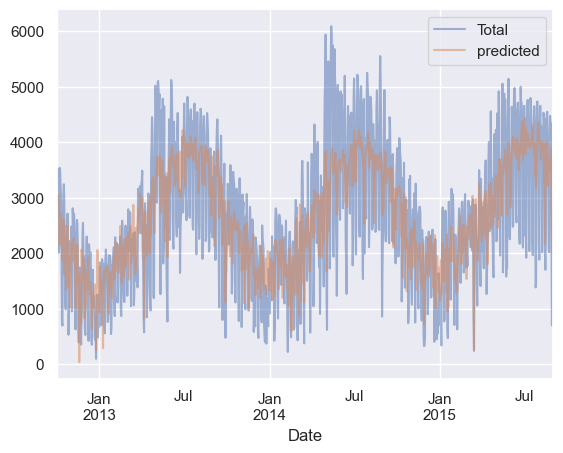

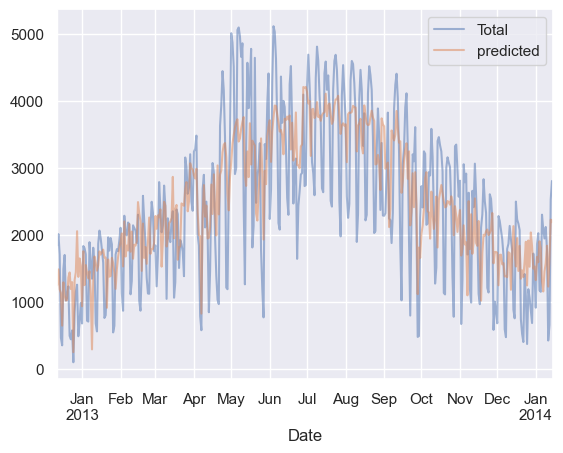

In [383]:
daily_df[['Total', 'predicted']].plot(alpha=0.5)
daily_df[['Total', 'predicted']].iloc[70:470].plot(alpha=0.5)

It is evident that we have missed some key features, especially during the summer time.
Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).